# Network Visualization and Dose Response Analysis of the L1000 POL Dataset
_Qiaonan Duan_ and _Avi Ma'ayan_

_Icahn School of Medicine at Mount Sinai_; _Department of Pharmacology and Systems Therapeutics_; _BD2K-LINCS Data Coordination and Integration Center_; _One Gustave L. Levy Place, Box 1603, New York, NY 10029 USA_

## Introduction

### Data preparation
* Download the _POL.tar.gz_ file from _clue.io_.
2. Unpack the zipped file.
3. There should be several files in the unpacked folder. The following files are used in the data preparation:
    * *Level3_INF_mlr12k_n5592x22268_2016_04-05.gct*
    * *siginfo.txt*
    * *instinfo.txt*
4. Set up a MongoDB database if not aready so.
5. Send the metadata of both the level 3 gene expression profiles and the level 5 gene expression signatures to the MongoDB database by running the following script:


In [ ]:
import json
import pandas as pd

from pymongo import MongoClient
# assume a local MongoDB database is set up at 127.0.0.1. 
# Change the URL if the MongoDB database is set up at a different address.
client = MongoClient('127.0.0.1', 27017)
# initialize the database
db = client['L1000_POL']
# initialize the level 3 metadata collection
instColl = db['inst']
# initialize the level 5 metadata collection
sigColl = db['sig']

# read the level 3 metadata file and send the content to the level 3 metadata collection.
# The metadata of a gene expression profile is stored as a row in the file and represented 
# as a document in the level 5 collection.
with open('instinfo.txt','r') as sf:
    header = next(sf)
    header = header.strip('\r\n\t').split('\t')
    header.append('batch')
    for row in sf:
        splits = row.strip('\r\n\t').split('\t')
        batch = '_'.join(splits[0].split('_')[:3])
        splits.append(batch)
        # zip into a dictonry
        doc = dict(zip(header,splits))
        instColl.save(doc)

# read the level 5 metadata file and send the content to the level 5 metadata collection.
# The metadata of a gene expression signature is stored as a row in the file and represented 
# as a document in the level 5 collection.
with open('siginfo.txt','r') as sf:
    header = next(sf)
    header = header.strip('\r\n\t').split('\t')
    for row in sf:
        splits = row.strip('\r\n\t').split('\t')
        splits2 = []
        for split in splits:
            # An array field is represented as a string with values seperated by '|'.
            furtherSplits = split.split('|')
            if len(furtherSplits)>1:
                splits2.append(furtherSplits)
            else:
                splits2.append(split)
        doc = dict(zip(header,splits2))
        sigColl.save(doc)

### Processing the L1000 POL gene expression data into CD signatures
A processing pipeline was implemented in Matlab to process the L1000 POL data into CD signatures. It is located in the _Processing to CDs_ folder.
* Add to _mongo2.12.3.jar_ in the folder to the dynamic Java class path of Matlab
2. Download the Matlab library of the CMAP l1ktools at https://github.com/cmap/l1ktools/tree/master/matlab/lib and add it to the Matlab path.
3. run the _main.m_ file to start the pipeline. It may take up to a day to process all the L1000 POL data into CD signatures. The processed signatures are saved in a collection called "cd" in the L1000_POL database.

### Network visualization of the L1000 POL CD signatures
* Create a network of CD signatures and save it in a gexf file using the following script:

In [ ]:
# connect to the MongoDB database
from pymongo import MongoClient
client = MongoClient('127.0.0.1', 27017)
db = client['L1000_POL']
cdColl = db['cd']

import networkx as nx
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# get landmark CD signatures and their metadata from the database
mat = []
docs = []
for doc in cdColl.find({},{'sig_id':True,'chdirLm':True,'pert_mfc_id':True,
                       'pvalue':True,'pert_id':True,'pert_dose':True,
                       'pert_iname':True,'pert_time':True,'cell_id':True,
                       '_id':False}):
    # the landmark CD signatures are added in to a matrix
    mat.append(doc['chdirLm'])
    docs.append(doc)

mat = np.asmatrix(mat)
dist = pdist(mat,'cosine')
# pair-wise cosine distance matrix
dist = squareform(dist)
thres = 0.5
# transform the distance matrix into an adjacency matrix using the 0.5 threshold
binaryDist = dist<=thres
# node is not self-connected
np.fill_diagonal(binaryDist,False)
# create a networkx object from the adjacency matrix
G = nx.from_numpy_matrix(binaryDist)

# add metadata to each node in the networkx object
attributesByIndex = {}
for i,doc in enumerate(docs):
    for key in doc:
        if key == 'chdirLm':
            continue
        if key not in attributesByIndex:
            attributesByIndex[key] = {}
        attributesByIndex[key][i] = doc[key]
for key in attributesByIndex:
    nx.set_node_attributes(G,key,attributesByIndex[key])

# wirte the network stored in the networkx object into a gexf file
nx.write_gexf(G,'POL.gexf')

* Download and install Gephi from https://gephi.org/ .
3. Load the _POL.gexf_ file into Gephi and choose the ForceAtlas2 algorithm to compute the best layout.
4. Color the nodes using one of the three attributes: perturbagen, dose, and cell line. 
5. The network visualizations colored by the  three attributes are displayed as follows:

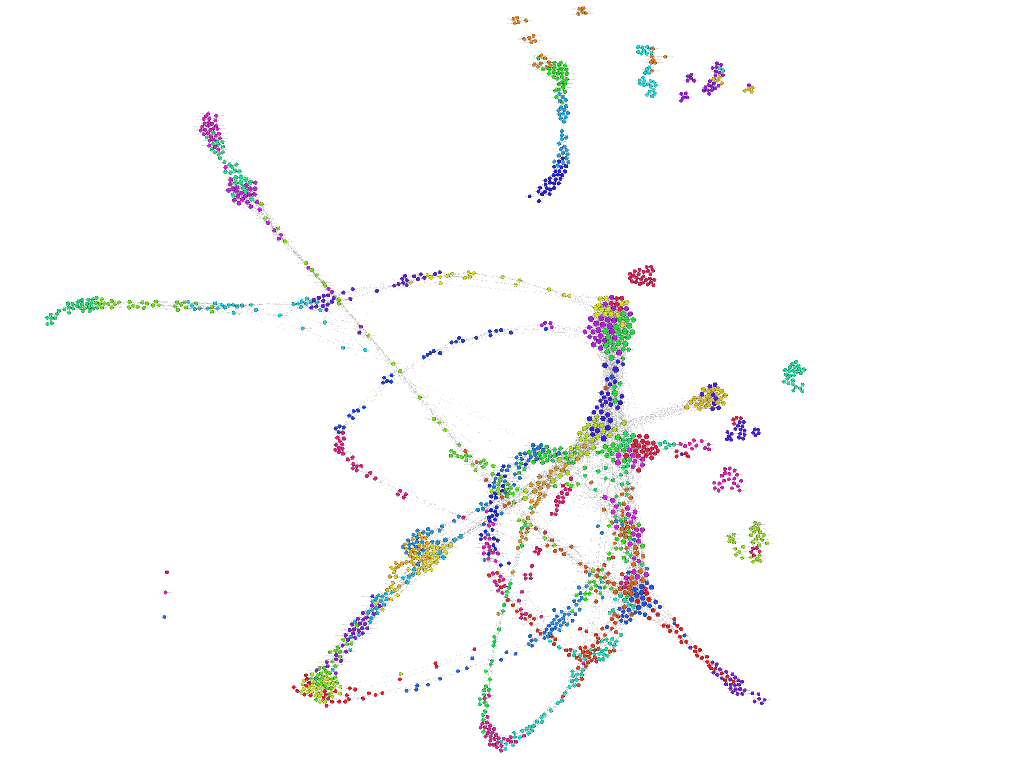

In [1]:
from IPython.display import Image
Image('img/pert.png', width='600')

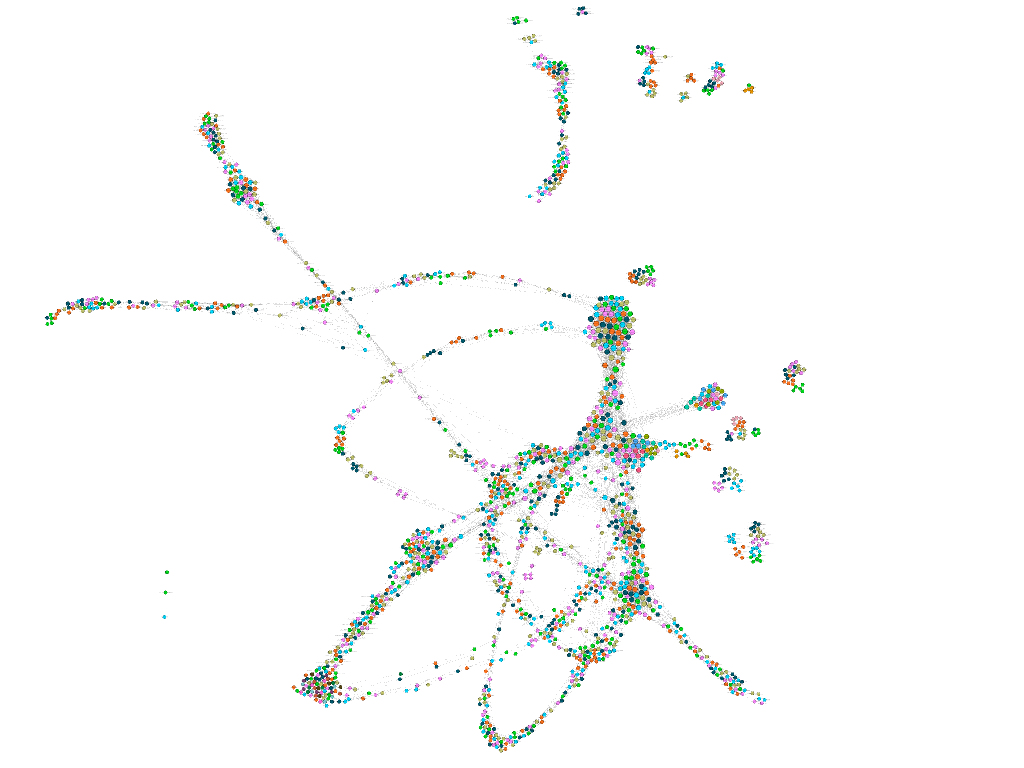

In [2]:
Image('img/dose.png', width='600')

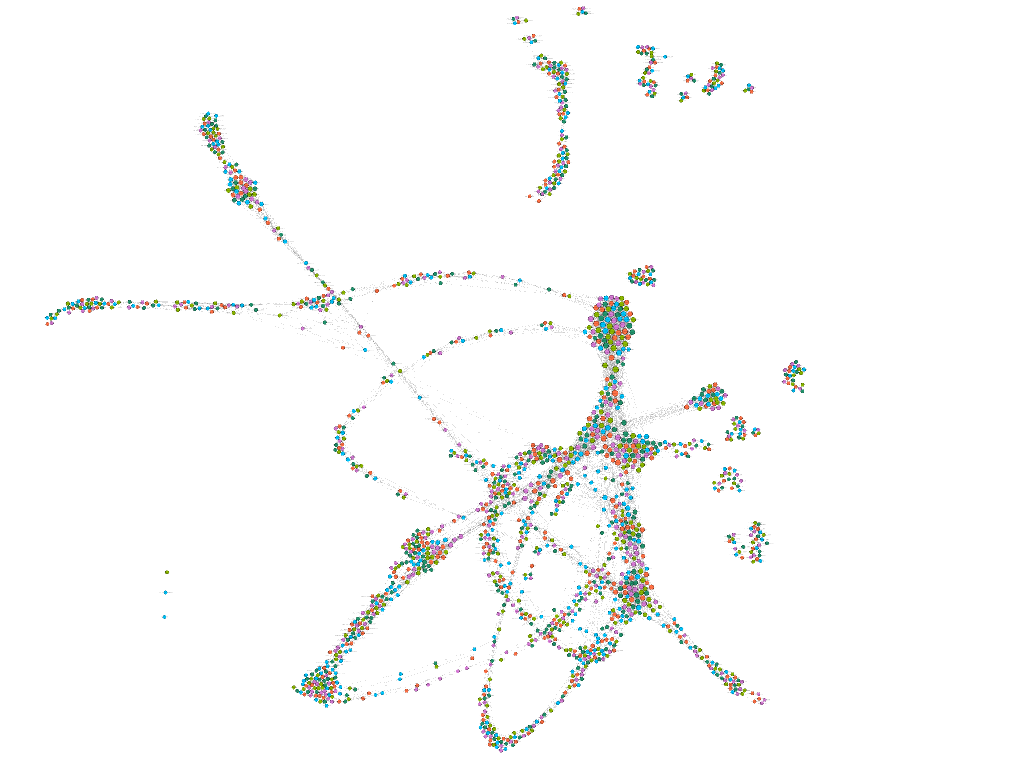

In [3]:
Image('img/cell.png', width='600')

* The network visualization colored by perturbagen was mannually editted and annotated  in Adobe Illustrator and presented below:

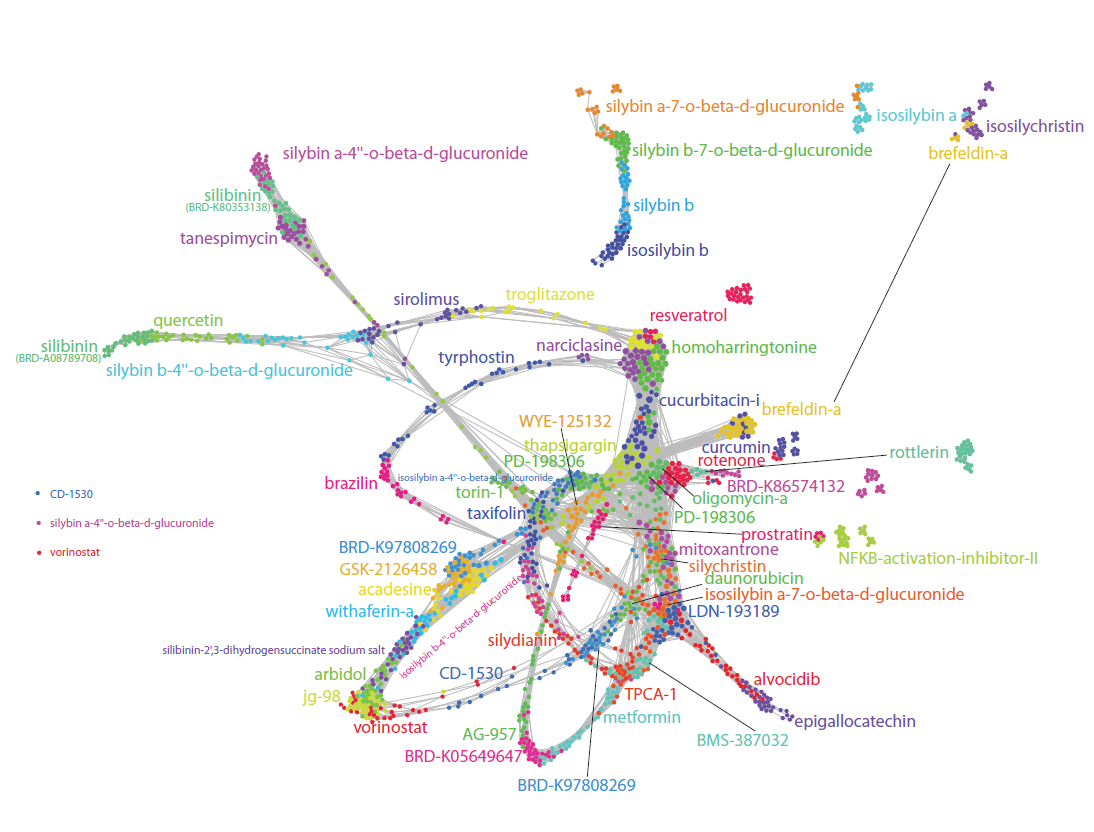

In [4]:
Image('img/pert_annotated.png', width='600')

### Dose Response Analysis of the L1000 POL CD signatures
Since dose has a significant influence on the transcriptional landscape of the L1000 POL data, the following script was written to investigate what are the perturbagens that have dose specific responses and at what doses the responses are specific.

In [ ]:
import pandas as pd
from itertools import combinations
import numpy as np
from scipy.spatial.distance import cdist,pdist
from scipy.misc import comb
import matplotlib.pyplot as plt

# connect to the MongoDB database
from pymongo import MongoClient
client = MongoClient('127.0.0.1', 27017)
db = client['L1000_POL']
cdColl = db['cd']

# create a collection that group CD signatures by pert and dose
cdColl.aggregate([{'$group':{'_id':{'pert_id':'$pert_id','pert_dose':'$pert_dose'},
                             'cell_id':{'$addToSet':"$cell_id"},
                            'sig_id':{'$addToSet':'$sig_id'}}},
                 {'$out':'byPertDose'}])

byPertDoseColl = db['byPertDose']
sigCountByDose = [len(doc['sig_id']) for doc in byPertDoseColl.find()]
sigCountByDose = pd.Series(sigCountByDose)
# create a histgram to see how many doses each perturbagen was applied at
sigCountByDose.hist()

# Examine if dose specific responses exist for each perturbagen
uniqPert_ids = byPertDoseColl.distinct('_id.pert_id')
for pert_id in uniqPert_ids:
    print(pert_id)
    # add CDs to each dose group of the current perturbagen
    byDoseGroups = list(byPertDoseColl.find({'_id.pert_id':pert_id}))
    for group in byDoseGroups:
        group['cds'] = []
        group['pairwiseCount'] = int(comb(len(group['sig_id']),2))
        for sig_id in group['sig_id']:
            doc = cdColl.find_one({'sig_id':sig_id})
            group['cds'].append(doc['chdirLm'])
    
    # compute the cosine distances between CDs of different doses
    cosDistsBetweenCdOfDifferentDose = []
    for combinationByDose in combinations(byDoseGroups,2):
        distMat = cdist(np.asmatrix(combinationByDose[0]['cds']),
                      np.asmatrix(combinationByDose[1]['cds']),'cosine')
        dists = list(np.asarray(distMat).reshape(-1))
        cosDistsBetweenCdOfDifferentDose += dists
    
    # null distribution of the average of the cosine distances between "sigCount" number of CDs
    sampleCount = 10000    
    nullDistributions = {}
    for pairwiseCount in set([group['pairwiseCount'] for group in byDoseGroups]):
        nullDistributions[pairwiseCount] = np.array([np.average(
        np.random.choice(cosDistsBetweenCdOfDifferentDose,
                         pairwiseCount,False)) for i in range(sampleCount)])
    
    # compute dose sepcific pvalues for each dose group and send to MongoDB
    for group in byDoseGroups:
        dists = pdist(np.asmatrix(group['cds']),'cosine')
        group['avgDist'] = np.average(dists)
        group['pvalue'] = np.sum(nullDistributions[group['pairwiseCount']] 
        < group['avgDist']) / sampleCount
        byPertDoseColl.update_one({'_id':group['_id']},
                                   {'$set':{'avgDist':group['avgDist'],
                                            'pvalue':group['pvalue']}})
# plot a histgram of dose specific pvalues    
pvalues = [doc['pvalue'] for doc in byPertDoseColl.find()] 
plt.hist(pvalues)

# group the perturbagen & dose groups by perturbagen and add to "byPert" collection
byPertDoseColl.aggregate([{'$group':{'_id':'$_id.pert_id',
                                     'byDose':{'$addToSet':{
                                     'pert_dose':'$_id.pert_dose',
                                     'avgDist':'$avgDist',
                                     'pvalue':'$pvalue'}}}},
                        {'$out':'byPert'}])

# add more descriptive information to byPert collection
idToName = {}
for doc in cdColl.find():
    idToName[doc['pert_id']] = doc['pert_iname']
byPertColl = db['byPert']
for doc in byPertColl.find():
    byPertColl.update_one({'_id':doc['_id']},
                           {'$set':{'pert_iname':idToName[doc['_id']]}})

# create a table of dose specific responses
with open('dosePert.txt','w') as df:
    df.write('pert_iname\tpert_id\tsignificance count\tdose,pvalue\n')
    for doc in byPertColl.find():
        count = sum([item['pvalue']<0.01 for item in doc['byDose']])
        dosePval = [[item['pert_dose'],item['pvalue']] for item in doc['byDose']]
        dosePval = sorted(dosePval,key=lambda x:float(x[0]))
        detail = '\t'.join([item[0]+'um,'+str(item[1]) for item in dosePval])
        df.write('{0}\t{1}\t{2}\t{3}\n'.format(doc['pert_iname'],
                 doc['_id'],count,detail))

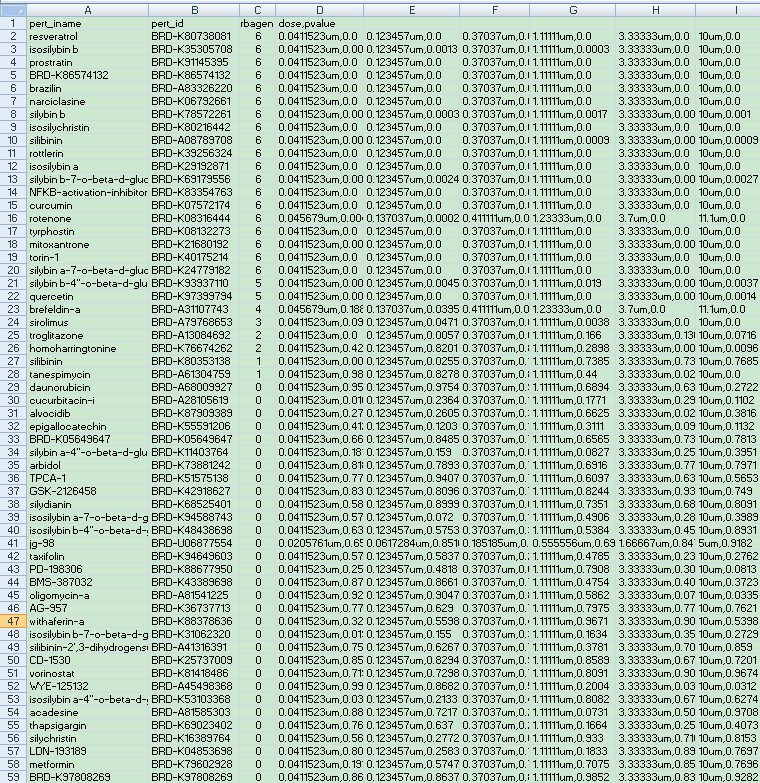

In [8]:
Image('img/table.png', width='800')

The results were saved in a tab-delimited file called  _dosePert.txt_. The numbers in the third column indicate at how many doses a perturbagen induces dose specific transcriptional responses.

## Conclusions and discussion
The network visualization shows that perturbagen is the most determinant factor of the transcriptional landscape of the L1000 POL data. Most CD signatures cluster by perturbagen. Dose is the second most influential factor of the transcriptional layout with many perturbagens showing dose specific responses. Cell line, on the other hand, shows almost no influence on the transcriptional responses. Considering the five cell lines used in the L1000 POL study are derived from different tissues, the homogenity of the responses across cell lines indicate that the pathways targeted by the perturbagens are well conserved in different tissues. In the dose response analysis, 20 perturbagens was found to induce strong dose specific responses at every dose. 31 perturbagens was shown to elicit no dose specific responses. The remaining 7 perturbagens induce dose sepcific responses in at least one of the six doses.